# Using Kaggle to download the dataset

In [ ]:
from google.colab import files
import kagglehub

files.upload()

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
path = kagglehub.dataset_download("eeshawn/flickr30k")
print(path)

100%|██████████| 4.08G/4.08G [00:39<00:00, 111MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/eeshawn/flickr30k/versions/1


# Declaring Addresses


## Delaring Addresses

In [3]:
import os, shutil, glob

drive_base = "/content/drive/MyDrive/captioneer"
drive_scripts = os.path.join(drive_base, "scripts")
drive_captions = os.path.join(drive_base, "processed_captions")

colab_scripts = "/content/scripts"
colab_captions = "/content/processed_captions"
colab_images = os.path.join(path, "flickr30k_images")

os.makedirs(colab_scripts, exist_ok=True)
os.makedirs("/content/models", exist_ok=True)

## Copying Scripts

In [24]:
for fname in ["dataset_attention.py", "model_attention.py", 'train_attention.py']:
    src = os.path.join(drive_scripts, fname)
    dst = os.path.join(colab_scripts, fname)
    if os.path.exists(dst):
        os.remove(dst)
    if os.path.exists(src):
        shutil.copy(src, dst)
        print("Copied", fname, "to", dst)
    else:
        print("not found in drive:", src)
print("Scripts placed in", colab_scripts)

Copied dataset_attention.py to /content/scripts/dataset_attention.py
Copied model_attention.py to /content/scripts/model_attention.py
Copied train_attention.py to /content/scripts/train_attention.py
Scripts placed in /content/scripts


## Copying `processed_captions`

In [25]:
import glob

# copy captions folder
if os.path.exists(colab_captions):
    print("Removing existing", colab_captions)
    shutil.rmtree(colab_captions)
shutil.copytree(drive_captions, colab_captions)
print("Copied processed captions to", colab_captions)

# quick checks
images = glob.glob(os.path.join(colab_images, "*.jpg"))
print("Number of images:", len(images))
json_files = glob.glob(os.path.join(colab_captions, "*.json"))
print("Processed captions files:", json_files)

Removing existing /content/processed_captions
Copied processed captions to /content/processed_captions
Number of images: 31783
Processed captions files: ['/content/processed_captions/cleaned_captions.json', '/content/processed_captions/meta.json', '/content/processed_captions/vocab_idx2word.json', '/content/processed_captions/sequences_test.json', '/content/processed_captions/vocab_word2idx.json', '/content/processed_captions/sequences_val.json', '/content/processed_captions/sequences_train.json']


# Training

## Dataloader Creation

In [26]:
# Dataloader creation (uses dataset_attention.py)
import sys
sys.path.append('/content/scripts')
from importlib import reload
import dataset_attention
reload(dataset_attention)

from torch.utils.data import DataLoader

train_seq = os.path.join(colab_captions, "sequences_train.json")
val_seq = os.path.join(colab_captions, "sequences_val.json")
vocab_path = os.path.join(colab_captions, "vocab_word2idx.json")

# dataset + loader (small batch for checking)
batch_size = 8
ds = dataset_attention.CaptionImageDataset(train_seq, colab_images, vocab_json=vocab_path, image_size=224)
loader = DataLoader(ds, batch_size=batch_size, shuffle=True, collate_fn=dataset_attention.collate_fn, num_workers=2)

# inspect one batch
images, seqs, names = next(iter(loader))
print("Images shape:", images.shape)
print("Seqs shape:", seqs.shape)
print("Sample image names:", names[:4])

Images shape: torch.Size([8, 3, 224, 224])
Seqs shape: torch.Size([8, 30])
Sample image names: ['3162940296.jpg', '184256548.jpg', '3433062788.jpg', '10101477.jpg']


## Importing and Preparation
double checking libraries and paths and scripts

In [33]:
# Importing and Preparation
import os, sys, json, torch
from importlib import reload
import model_attention, train_attention
reload(model_attention)
reload(train_attention)

# paths
colab_captions = "/content/processed_captions"
colab_images = os.path.join(path, "flickr30k_images")
vocab_path = os.path.join(colab_captions, "vocab_word2idx.json")
idx2word_path = os.path.join(colab_captions, "vocab_idx2word.json")
train_seq = os.path.join(colab_captions, "sequences_train.json")
val_seq = os.path.join(colab_captions, "sequences_val.json")
test_seq = os.path.join(colab_captions, "sequences_test.json")
models_dir = "/content/models"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# load vocab jsons
with open(vocab_path, "r", encoding="utf-8") as f:
    word2idx = json.load(f)
with open(idx2word_path, "r", encoding="utf-8") as f:
    raw_idx2 = json.load(f)
idx2word = {int(k): v for k, v in raw_idx2.items()}

start_token = word2idx.get("<START>", 2)
end_token = word2idx.get("<END>", 3)
pad_token = word2idx.get("<PAD>", 0)
print("Vocab size:", len(word2idx))

Device: cuda
Vocab size: 4998


## Sanity Check

In [28]:
feat_dim = 2048
feat_embed_dim = 512
embed_dim = 512
hidden_dim = 1024
num_layers = 1
dropout = 0.5

enc = model_attention.EncoderCNN(feat_dim=feat_dim, feat_embed_dim=feat_embed_dim, train_backbone=False).to(device)
dec = model_attention.DecoderWithAttention(embed_dim=embed_dim, hidden_dim=hidden_dim,
                                 vocab_size=len(word2idx), feat_dim=feat_dim,
                                 feat_embed_dim=feat_embed_dim, attn_dim=512,
                                 num_layers=num_layers, dropout=dropout).to(device)

# single-batch forward pass (sanity)
images, seqs, names = next(iter(loader))
images = images.to(device)
seqs = seqs.to(device)

enc.train(); dec.train()
feats, global_feat = enc(images)
print("Encoder feats shape:", feats.shape, "global shape:", global_feat.shape)
logits = dec(feats, seqs)
print("Decoder logits shape:", logits.shape)

# simple loss step
criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_token)
B, Lm1, V = logits.shape
loss = criterion(logits.view(B*Lm1, V), seqs[:,1:].reshape(-1))
print("One-step train loss:", loss.item())

Encoder feats shape: torch.Size([8, 49, 512]) global shape: torch.Size([8, 512])
Decoder logits shape: torch.Size([8, 29, 4998])
One-step train loss: 8.530060768127441


In [ ]:
reload(train_attention)

config = {
    'train_sequences': train_seq,
    'val_sequences': val_seq,
    'images_dir': colab_images,
    'vocab_path': vocab_path,
    'save_dir': models_dir,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'batch_size': 256,
    'epochs': 50,
    'lr': 1e-3,
    'patience': 7,
    'embed_dim': embed_dim,
    'hidden_dim': hidden_dim,
    'num_layers': num_layers,
    'dropout': dropout,
    'feat_dim': feat_dim,
    'feat_embed_dim': feat_embed_dim,
    'max_len': 30,
    'resume_path': "/content/drive/MyDrive/captioneer/models_attention/best_model_epoch13_bleu0.2031.pt"
}

history = train_attention.train_loop(config)

## Visualizing Losses & Scores

In [ ]:
import matplotlib.pyplot as plt

print(history)

# Plot losses
plt.figure(figsize=(10,5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot BLEU scores
plt.figure(figsize=(10,5))
plt.plot(history["val_bleu"], marker="o", label="Val BLEU")
plt.xlabel("Epoch")
plt.ylabel("BLEU Score")
plt.title("Validation BLEU Evolution")
plt.legend()
plt.grid(True)
plt.show()

## Load Best Model And Check Generated Captions VS Ground Truth

Loading best model: /content/models/best_model_epoch14_bleu0.2049.pt


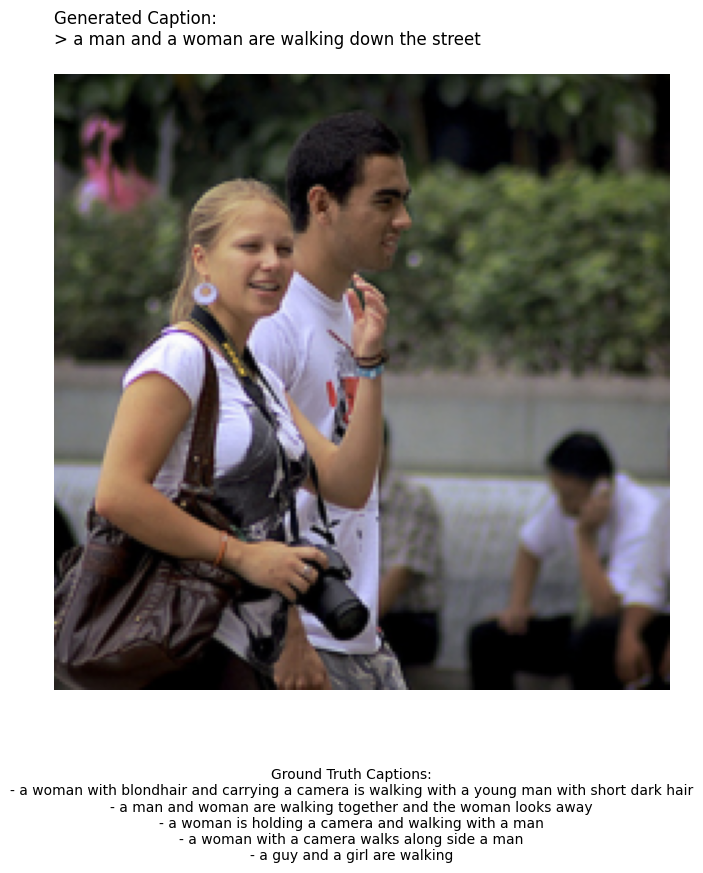

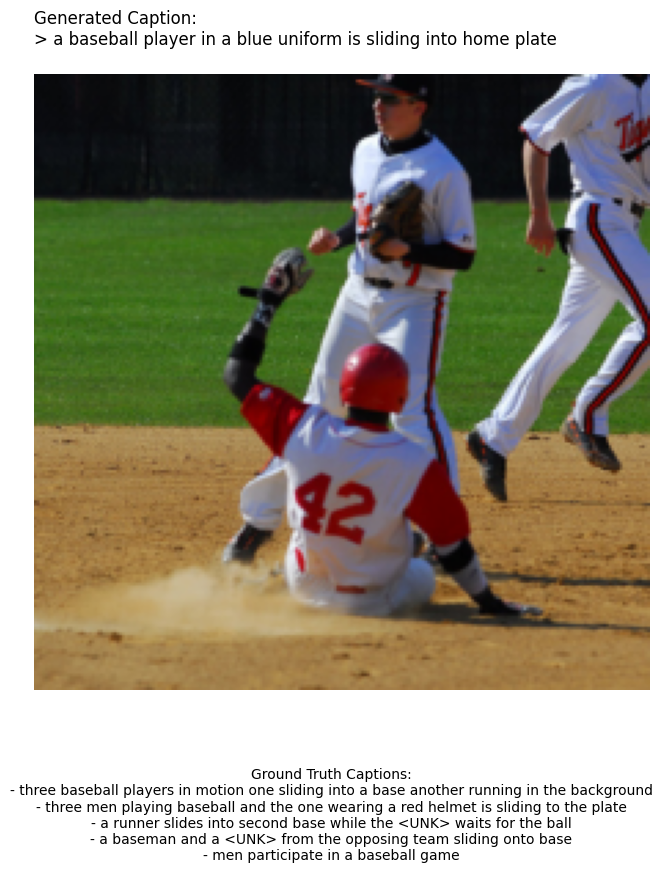

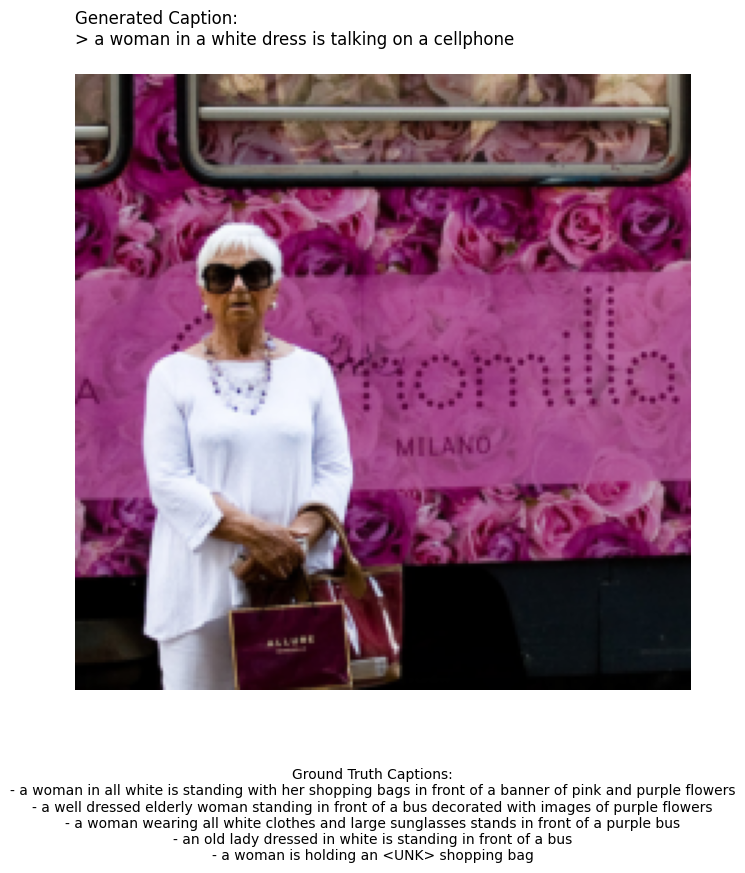

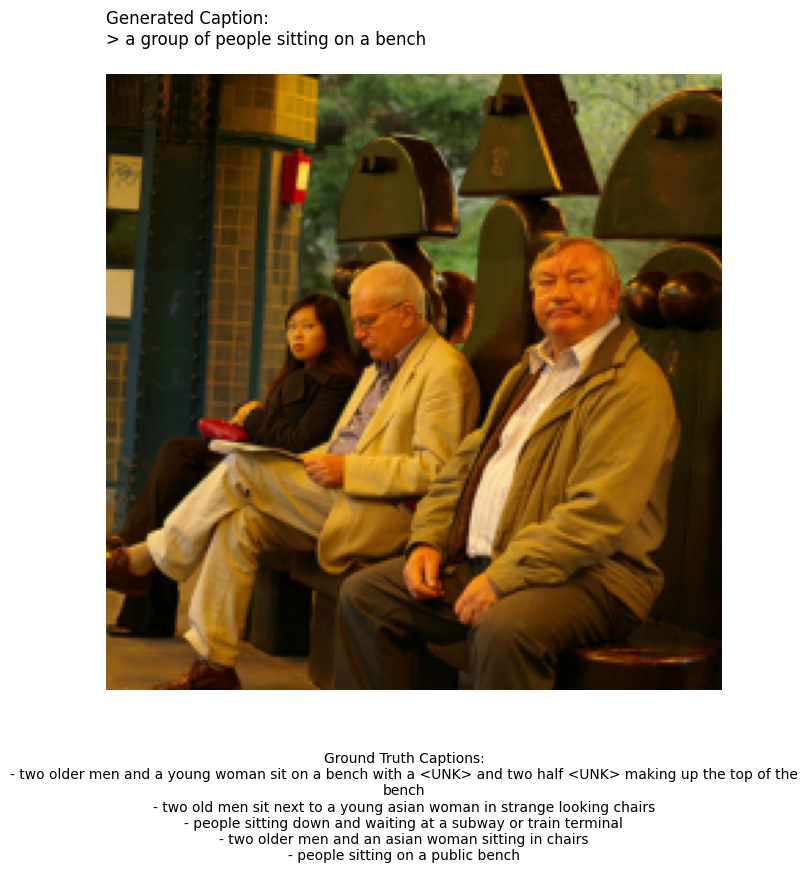

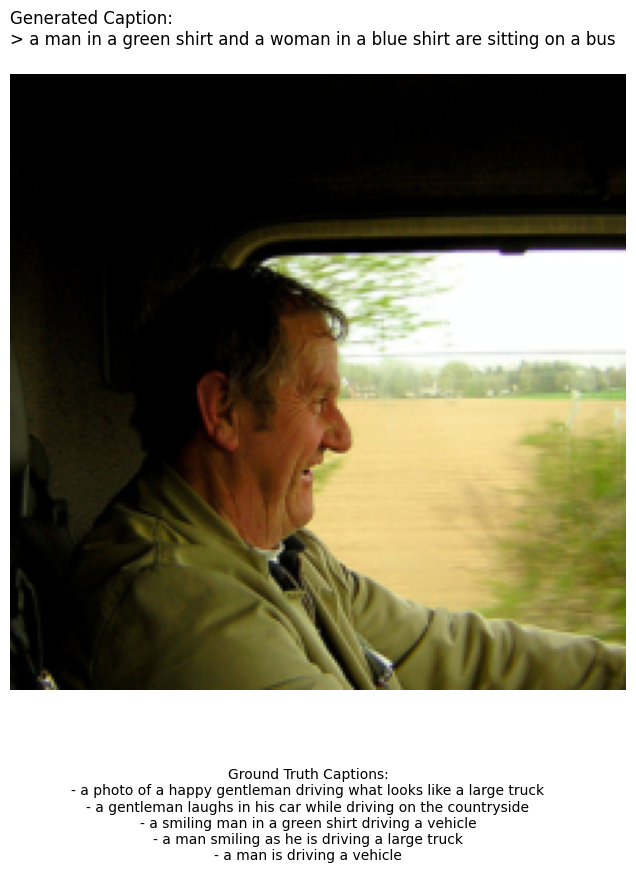

In [40]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
import glob
import random

reload(model_attention)
reload(train_attention)

# Find the best model checkpoint
list_of_files = glob.glob(os.path.join(models_dir, '*.pt'))
if not list_of_files:
    print("No trained models found in the directory.")
else:
    best_model_path = max(list_of_files, key=os.path.getctime)
    print(f"Loading best model: {best_model_path}")

    # Initialize models
    encoder = model_attention.EncoderCNN(
        feat_dim=config['feat_dim'],
        feat_embed_dim=config['feat_embed_dim']
    ).to(device)
    decoder = model_attention.DecoderWithAttention(
        embed_dim=config['embed_dim'],
        hidden_dim=config['hidden_dim'],
        vocab_size=len(word2idx),
        feat_embed_dim=config['feat_embed_dim']
    ).to(device)

    # Load state dictionaries
    checkpoint = torch.load(best_model_path, map_location=device)
    encoder.load_state_dict(checkpoint['encoder_state'])
    decoder.load_state_dict(checkpoint['decoder_state'])
    encoder.eval()
    decoder.eval()

    test_ds = dataset_attention.CaptionImageDataset(
        test_seq, colab_images, vocab_path, is_val=True
    )
    test_loader = DataLoader(
        test_ds, batch_size=1, shuffle=True, collate_fn=dataset_attention.collate_fn
    )

    def sequence_to_text(seq, idx2word_map):
        return ' '.join([idx2word_map[idx] for idx in seq if idx not in {start_token, end_token, pad_token}])

    # Generate and display captions
    num_samples_to_show = 5
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    with torch.no_grad():
        for i, (image_t, caps_t_list, img_name) in enumerate(test_loader):
            if i >= num_samples_to_show:
                break

            image_t = image_t.to(device)

            # Generate caption using beam search
            feats, _ = encoder(image_t)
            prediction_idx = decoder.beam_search_decode(feats, start_token, end_token)[0]
            predicted_caption = sequence_to_text(prediction_idx, idx2word)

            # Prepare ground truth captions
            gt_captions = [sequence_to_text(cap.squeeze().tolist(), idx2word) for cap in caps_t_list[0]]

            # Display the image and captions
            img_display = image_t.squeeze(0).cpu().numpy().transpose((1, 2, 0))
            img_display = std * img_display + mean
            img_display = np.clip(img_display, 0, 1)

            plt.figure(figsize=(8, 8))
            plt.imshow(img_display)
            plt.axis('off')
            plt.title(f"Generated Caption:\n> {predicted_caption}\n", loc='left')

            gt_text = "Ground Truth Captions:\n" + "\n".join([f"- {cap}" for cap in gt_captions])
            plt.figtext(0.5, -0.1, gt_text, ha="center", fontsize=10, wrap=True)

            plt.show()